In [1]:
from tensorflow import keras
print('keras: ', keras.__version__)

keras:  2.8.0


### Demo: Implementing a 1D convnet  <a id='demo' />

In Keras, you would use a 1D convnet via the `Conv1D` layer, which has a very similar interface to `Conv2D`. It takes as input 3D tensors with shape `(samples, time, features)` and also returns similarly-shaped 3D tensors. The convolution window is a 1D window on the temporal axis, axis 1 in the input tensor.

Let's build a simple 2-layer 1D convnet and apply it to the IMDB sentiment classification task that you are already familiar with.

As a reminder, this is the code for obtaining and preprocessing the data:

In [6]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
max_len = 100  # cut texts after this number of words (among top max_features most common words)

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)


1D convnets are structured in the same way as their 2D counter-parts you have learned earlier: they consist of a stack of `Conv1D` and `MaxPooling1D` layers, eventually ending in either a global pooling layer or a `Flatten` layer, turning the 3D outputs into 2D outputs, allowing to add one or more `Dense` layers to the model, for classification or regression.

One difference, though, is the fact that we can afford to use larger convolution windows with 1D convnets. Indeed, with a 2D convolution layer, a 3x3 convolution window contains 3*3 = 9 feature vectors, but with a 1D convolution layer, a convolution window of size 3 would only contain 3 feature vectors. We can thus easily afford 1D convolution windows of size 7 or 9.

This is our example 1D convnet for the IMDB dataset:

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 32, input_length=max_len))
model.add(layers.Conv1D(16, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(16, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_split=0.2)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 32)           320000    
                                                                 
 conv1d_14 (Conv1D)          (None, 94, 16)            3600      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 18, 16)           0         
 1D)                                                             
                                                                 
 conv1d_15 (Conv1D)          (None, 12, 16)            1808      
                                                                 
 global_max_pooling1d_7 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_7 (Dense)             (None, 1)                

Here are our training and validation results: validation accuracy is somewhat lower than that of the LSTM we used previously, but 
runtime is faster, both on CPU and GPU (albeit the exact speedup will vary greatly depending on your exact configuration). At that point, 
we could re-train this model for the right number of epochs (8), and run it on the test set. This is a convincing demonstration that a 1D 
convnet can offer a fast, cheap alternative to a recurrent network on a word-level sentiment classification task.

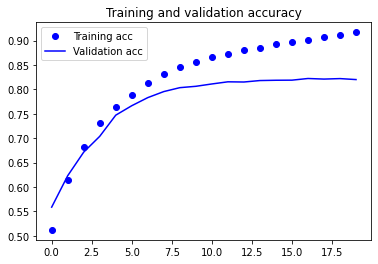

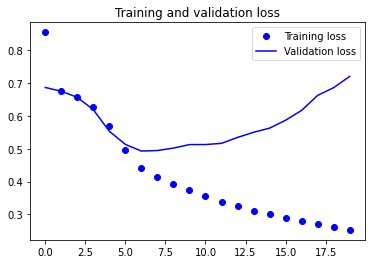

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In Summary:
* In the same way that 2D convnets perform well for processing visual patterns in
2D space, 1D convnets perform well for processing temporal patterns. They
offer a faster alternative to RNNs on some problems, in particular natural language
processing tasks.
* Typically, 1D convnets are structured much like their 2D equivalents from the
world of computer vision: they consist of stacks of Conv1D layers and Max-
Pooling1D layers, ending in a global pooling operation or flattening operation.